# Lesson 01- Electrocardiogram graphing and basic analysis

### Ana Daniela del Río Pulido<sup>1</sup> and Erin C. McKiernan<sup>2</sup>

<sup>1</sup> Licenciatura en Física Biomédica, Facultad de Ciencias, UNAM <br/>
<sup>2</sup> Departamento de Física, Facultad de Ciencias, UNAM 

<sup>*This is the second lesson in an ECG course package available at https://github.com/emckiernan/electrocardiogram_analysis. Please see the main repository for more information. Lessons are shared under the terms of the [Creative Commons Attribution (CC BY) 4.0 International License](https://creativecommons.org/licenses/by/4.0/).</sup>

## Overview
In this data analysis practical, students will learn how to extract data and graph electrocardiogram (ECG) recordings obtained using the [Backyard Brains Heart and Brain SpikerBox](https://backyardbrains.com/products/heartAndBrainSpikerBox). Recordings for this practical can be collected by students by following the instructions in [Lesson 00 - Electrocardiography basics](https://github.com/emckiernan/electrocardiogram_analysis/tree/master/courseEnglish/00-ECGRecording), or students can work with existing recordings from our [data folder](https://github.com/emckiernan/electrocardiogram_analysis/tree/master/data). Students will learn how to identify and detect the main components of the ECG, including the P, QRS, and T waves. They will also learn how to calculate the R-R interval to determine the cardiac frequency. Finally, students will look at how these measures vary over the course of a recording. 

## Background and prerequisites
Prior to this lesson, it is recommended that students perform the recordings in [Lesson 00 - Electrocardiography basics](https://github.com/emckiernan/electrocardiogram_analysis/tree/master/courseEnglish/00-ECGRecording). If recording equipment is not available, students should at least read the background information in Lesson 00 to understand the basic function of the heart, its electrical activity, and the ECG.

Additional reading:
* D.E. Mohrman and L.J. Heller. Cardiovascular Physiology. Lange Medical Books/McGraw-Hill New York, 2006.
* Backyard Brains. Experiment: Heart action potentials. Available at https://backyardbrains.com/experiments/heartrate.
* OpenStax CNX. 19.2 Cardiac Muscle and Electrical Activity. In OpenStax, Anatomy & Physiology. Rice University. Available at https://openstax.org/books/anatomy-and-physiology/pages/19-2-cardiac-muscle-andelectrical-activity.

## Setting up the notebook

We begin by setting up our Jupyter notebook and importing the Python modules needed for plotting figures. We include commands to view plots inside the notebook, and to create figures with good resolution and large labels. These commands can be customized to produce figures with other specifications.

In [1]:
# command to view figures in Jupyter notebook
%matplotlib inline 

# import plotting module 
import matplotlib.pylab as plt 

# commands to create high-resolution figures with large labels
%config InlineBackend.figure_formats = {'png', 'retina'} 
plt.rcParams['axes.labelsize'] = 18 # fontsize for figure labels
plt.rcParams['axes.titlesize'] = 20 # fontsize for figure titles
plt.rcParams['font.size'] = 16 # fontsize for figure numbers
plt.rcParams['lines.linewidth'] = 1.6 # line width for plotting

Next, we import the modules and features needed to open files, extract and filter data, and perform computations.

In [3]:
import numpy as np
import wave
from statistics import stdev
import scipy as sc
from scipy import signal
from scipy.signal import butter,iirnotch,lfilter,filtfilt

## Extracting and graphing the data

ECG recordings were obtained using the [Backyard Brains Heart and Brain SpikerBox](https://backyardbrains.com/products/heartAndBrainSpikerBox). The recordings are saved as audio files in .wav format. The first thing we have to do is open the .wav files and extract the data using commands from the [wave module](https://docs.python.org/3/library/wave.html) we imported above. We can extract the number of recording channels, sampling rate, etc. and save this information in an array. Then we can graph the ECG recording.

In [4]:
'''
This function extracts the number of recording channels, sampling rate, and raw data. 
The first argument to the function is the path and filename of the .wav file, i.e. recording.
The second argument is for plotting; turn the graph on by setting argument equal to 1. 
Code adapted from examples in: https://www.programcreek.com/python/example/82393/wave.open
'''
def ECG(file, graph):
    record = wave.open(file) # load the data
    nChannels = record.getnchannels() # get number of channels
    nFrames = record.getnframes() # get number of frames
    sampleRate = record.getframerate() # get sampling rate
    dstr = record.readframes(nFrames * nChannels) # extract data 
    waveData = np.frombuffer(dstr, np.int16) # save data
    print('The recording has %d channel(s).' % (nChannels)) # print number of channels
    print('The sampling rate of the recording is %d Hz.' % (sampleRate)) # print sampling rate
    timeECG=np.linspace(0, len(waveData)/sampleRate, num=len(waveData)) # get time window
    freq = 1/np.mean(np.diff(timeECG)) # get frequency
    # save relevant data in array
    xx={'sampleRate':sampleRate,\
        'waveData':waveData,\
        'timeECG':timeECG,\
        'freq':freq} 
    
    # plot ECG; turn off by setting graph to 0
    if graph:    
        plt.figure(figsize=(18,6))
        plt.xlabel(r'time (s)')
        plt.ylabel(r'voltage ($\mu$V)')
        plt.plot(xx['timeECG'],xx['waveData'], 'b')
        plt.xlim(0,max(xx['timeECG']))
        plt.show()
    
    return xx

Now we can run the above function on one of the test files in the data folder. With graph=1, it will also plot the ECG recording.

The recording has 1 channel(s).
The sampling rate of the recording is 10000 Hz.


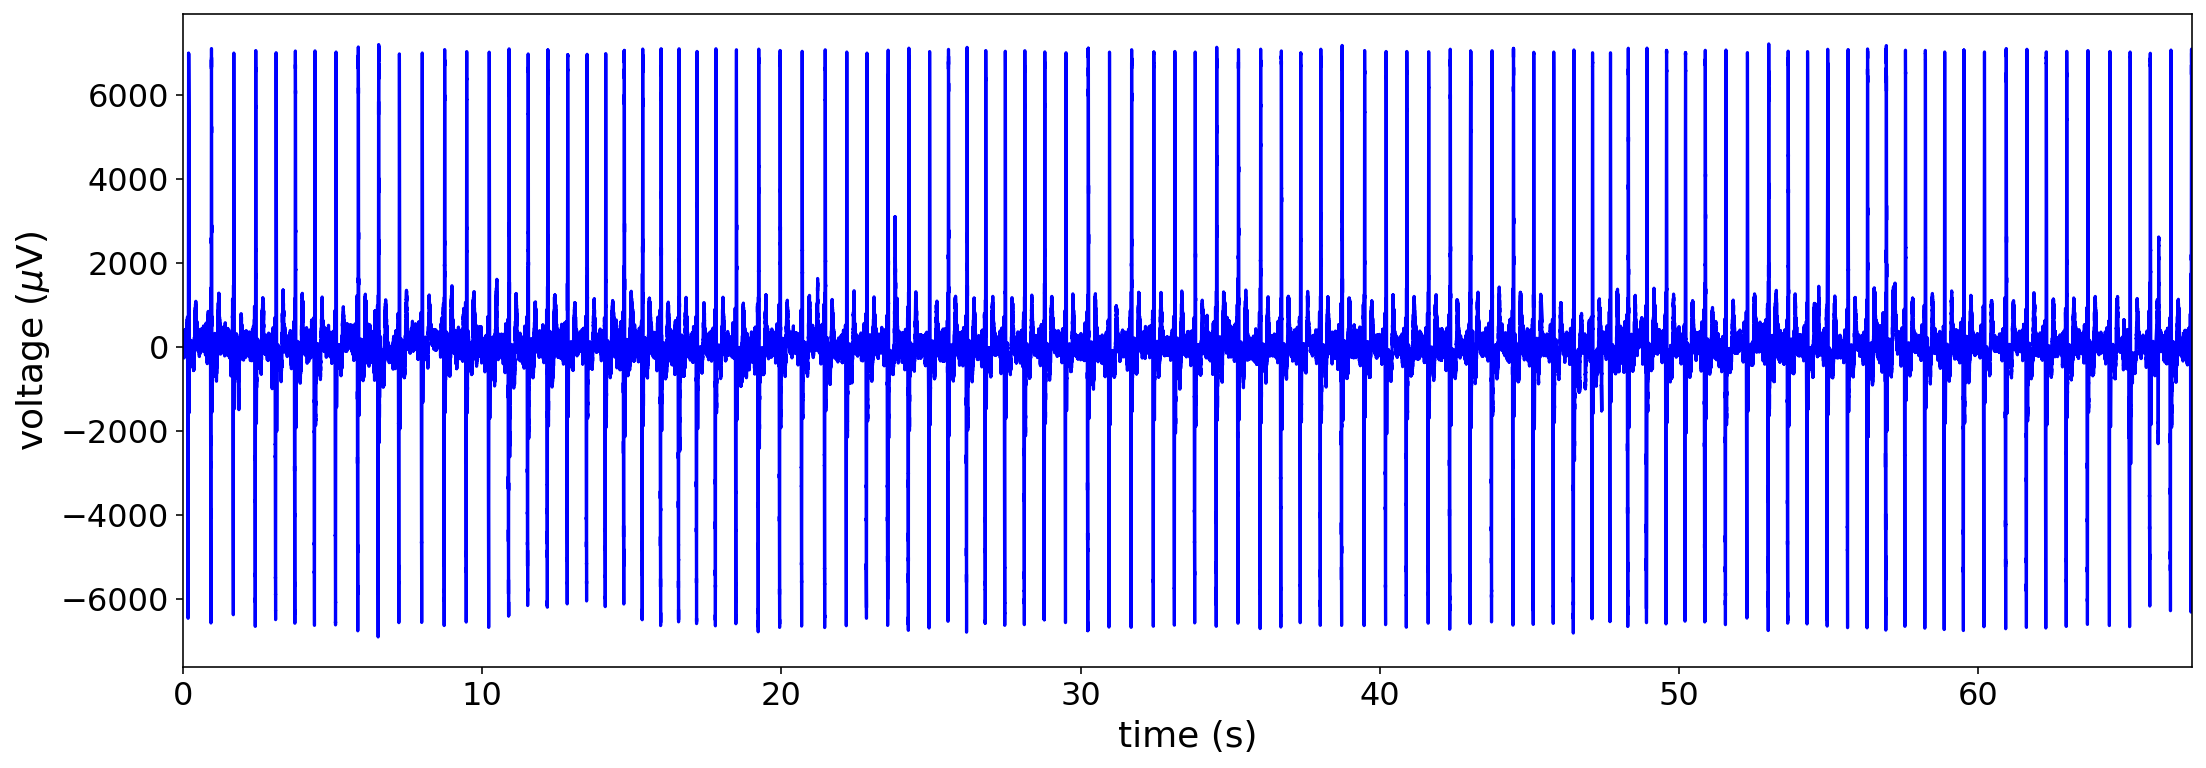

In [97]:
xx = ECG(file='../../data/S10_rest.wav', graph=1)

The above function will allow us to quickly run through several recordings and plot them to check whether we have quality, stable data, and how long the overall recording is. If we want to zoom in on a certain part of the recording to look at just a few cardiac cycles and better visualize the wave forms, we can either change the x-axis limits in the above function and re-run it, which will also re-run the whole data extraction. Or, we can simply construct a new figure with the saved data, as below. 

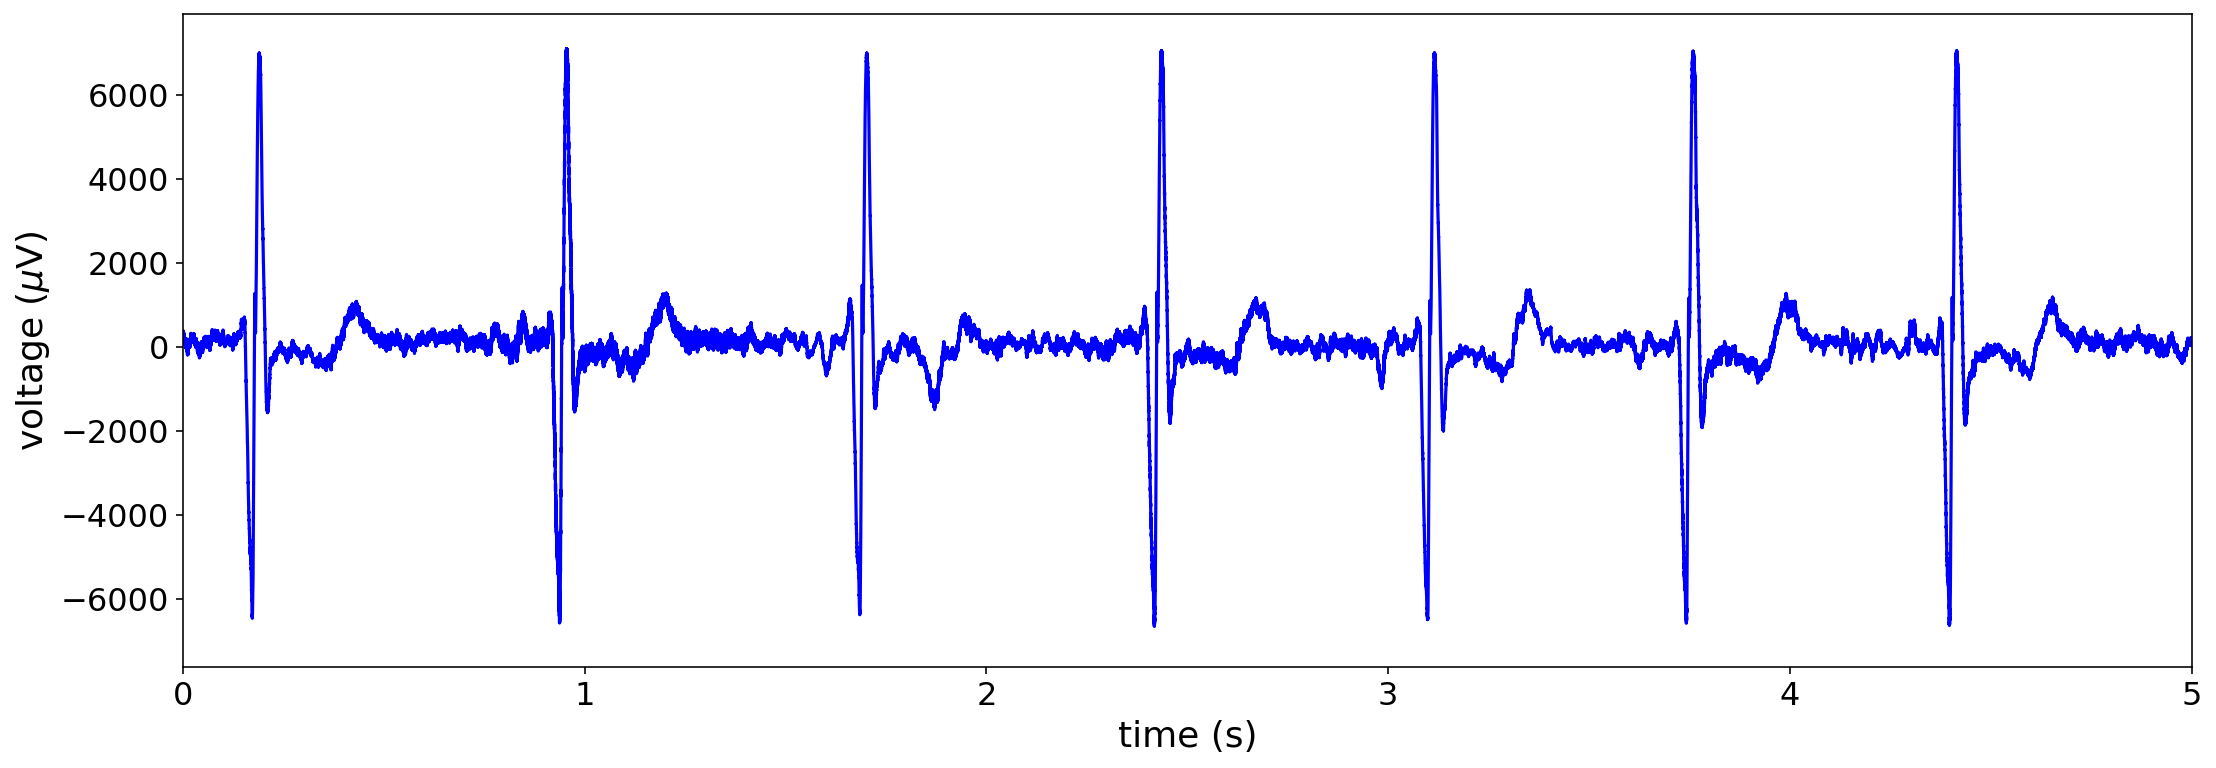

In [98]:
plt.figure(figsize=(18,6))
plt.plot(xx['timeECG'],xx['waveData'], 'b')
plt.xlim(0,5)
#plt.ylim(-9000,9000)
plt.xlabel(r'time (s)')
plt.ylabel(r'voltage ($\mu$V)')
plt.show()

Now we can see just two cardiac cycles, and clearly visualize the QRS complex and T wave in each (the P wave is hard to discern in this recording). We can also see that there is some noise that we might want to filter out.

## Filtering ECG data
ECG recordings are often filtered for a variety of reasons, including the presence of artifacts that can result from motion of the subject, or the presence of noise from various electrical sources. The type of filter used will depend on the characteristics we want to remove from the recording and the frequency of these events. We will not explore all filter types here, just a few examples. More information on ECG filtering can be found [here](http://ems12lead.com/2014/03/10/understanding-ecg-filtering/) and [here](http://www-classes.usc.edu/engr/bme/620/LectureECGNoise.pdf). 

We can start with a low-pass filter, which only lets through frequencies below a certain limit. In this case, we'll place the limit at 55 Hz to make sure no 60 Hz (or higher-frequency) noise remains. By plotting the filtered signal over the original, we can see that the low-pass filter does a good job of removing the high-frequency noise while maintaining the overall shape of the ECG signal. However, we do lose some of the amplitude in the QRS complex.

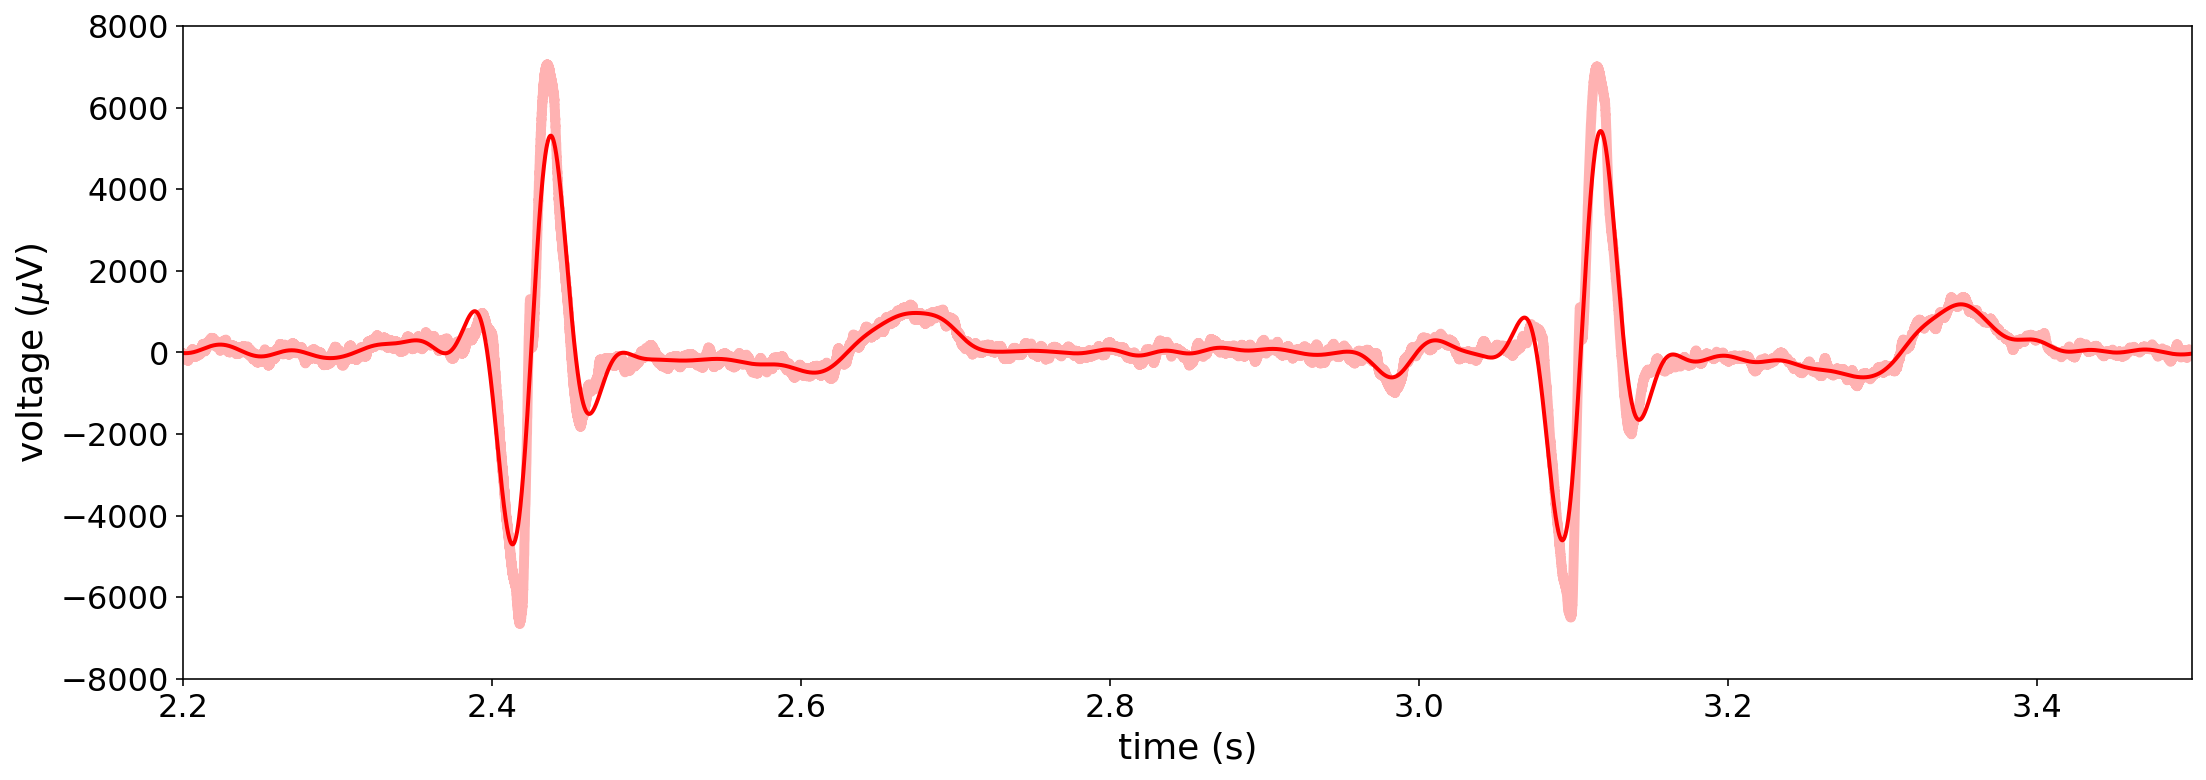

In [99]:
# define function to apply low-pass filter; cutoff set at 55 Hz
def lowPass(data,lowp):
    sfreq = xx['sampleRate']
    low_pass = lowp/sfreq
    b, a = sc.signal.butter(4, low_pass, btype='lowpass')
    datalf = filtfilt(b, a, data)
    
    # plot original and filtered ECG signals
    plt.figure(figsize=(18,6))
    plt.xlabel('time (s)')
    plt.ylabel('voltage ($\mu$V)')
    plt.plot(xx['timeECG'],data, 'r', linewidth=5.0, alpha=0.3) # original data
    plt.plot(xx['timeECG'],datalf, 'r', linewidth=2.0) # filtered data
    plt.xlim(2.2,3.5)
    plt.ylim(-8000,8000)

    return datalf

datalf = lowPass(data = xx['waveData'], lowp = 55);

We can instead use a band-pass filter, which only allows through frequencies between the specified lower and upper limits. Specifying the range 0.5 to 55Hz, we see that this filter also does a good job of removing the high-frequency noise, albeit with less 'smoothing' than the low-pass filter. However, with this filter, there is no significant loss  of amplitude.  

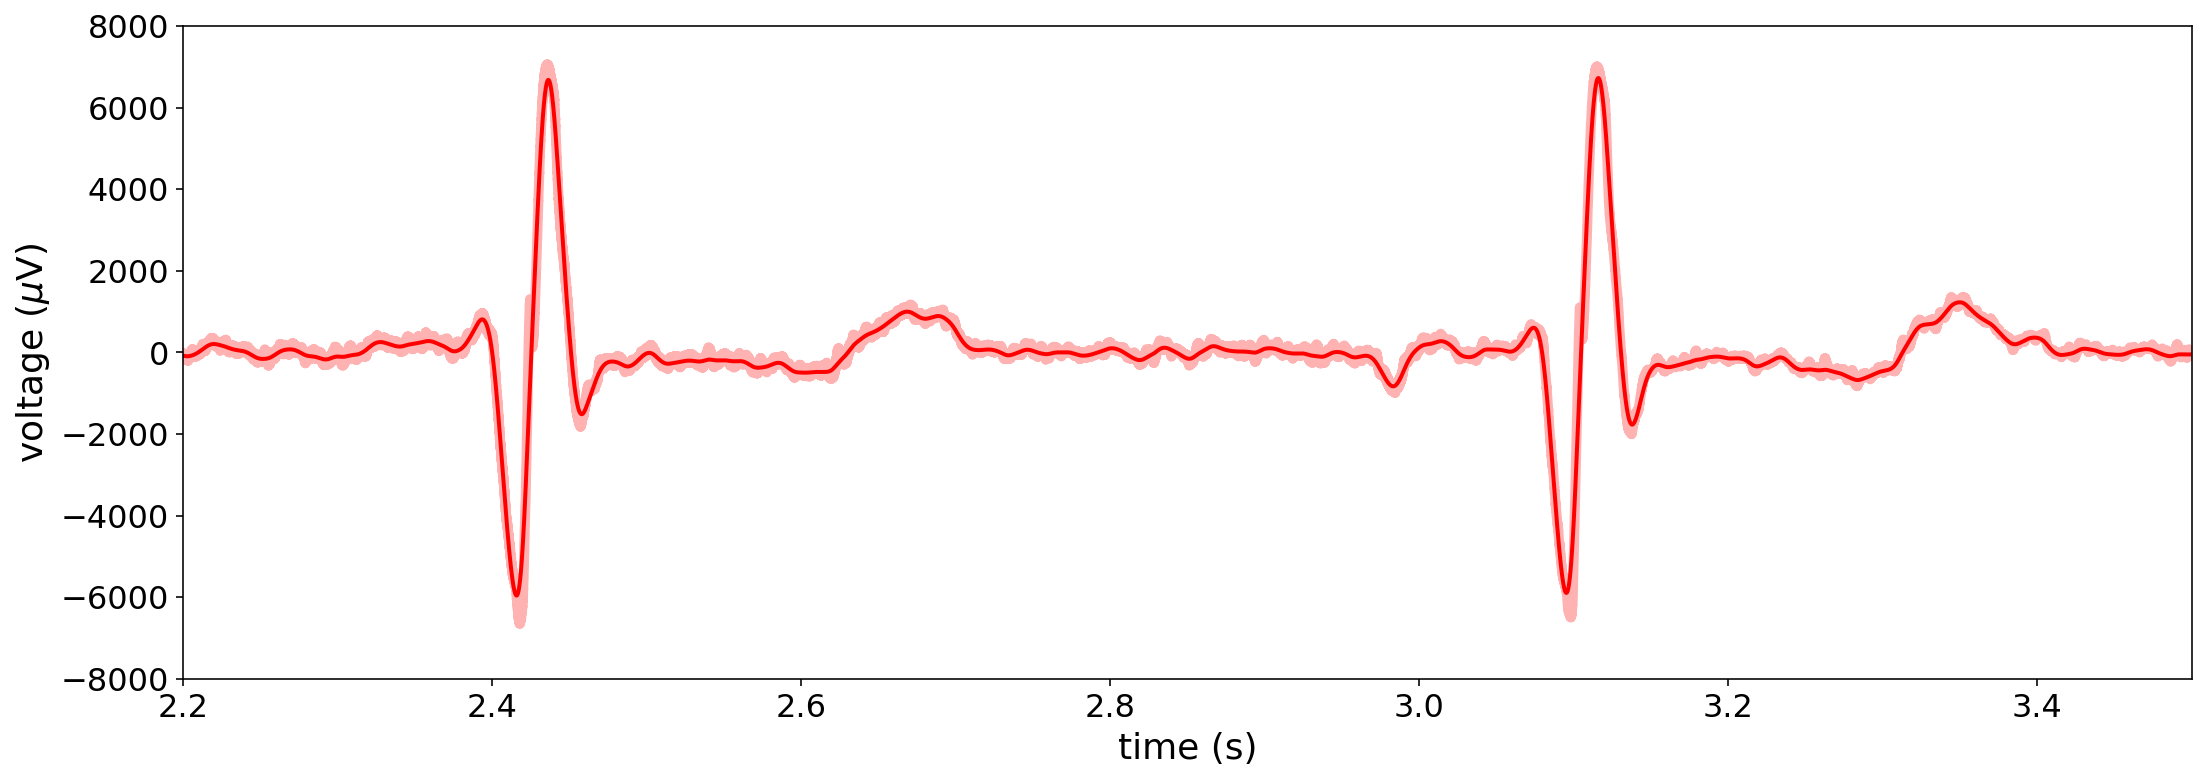

In [100]:
# define function to apply band-pass filter; range set to 0.5-55Hz
def bandPass(data,lowLim,upLim):
    b, a = butter(2, ([lowLim, upLim]/(xx['freq']/2)), btype = 'bandpass')
    databf = filtfilt(b, a, data)

    # plot original and filtered ECG signals
    plt.figure(figsize=(18,6))
    plt.xlabel(r'time (s)')
    plt.ylabel(r'voltage ($\mu$V)')
    plt.plot(xx['timeECG'],data, 'r', linewidth=5.0, alpha=0.3) # original data
    plt.plot(xx['timeECG'],databf, 'r', linewidth=2.0) # filtered data
    plt.xlim(2.2,3.5)
    plt.ylim(-8000,8000)
    
    return databf

databf = bandPass(data = xx['waveData'], lowLim = 0.5, upLim= 55);

### Study questions and exercises:
- Describe the effects of low-pass versus band-pass filtering the ECG signal.
- Why did we specify the frequency ranges we did? How is the frequency range used related to the physiological signal you are recording?
- What would happen if you changed the specified frequencies? Experiment with different filter frequencies. Graph and compare the results.
- Are there other types of filters you could use to remove noise or artifacts from the ECG recordings? Describe them and their advantages/disadvantages.

# Detecting ECG components

Once we've identified, opened, and filtered a recording we would like to analyze, the next task is to detect the different components of the ECG, including the R peaks, QRS complex, and P and T waves. Detecting these components will allow us to calculate things like heart rate, PR intervals, or other quantitative features of the ECG that are used to compare different conditions likes rest and exercise, or in clinical diagnosis.  

The detection will work best if we have a section of recording which is very stable and without any artifacts. So, before we begin, we take the recording we want to analyze and cut it to make sure we're analyzing a 'clean' section. We want to have complete cardiac cycles, so we will find the time before the P wave of the first cycle we want to analyze and label that n1, and then find the time after the T wave of the last cycle we want to analyze and label that n2. To find these times, let's first plot the whole recording. Remember that we are now working with the filtered data (databf). 

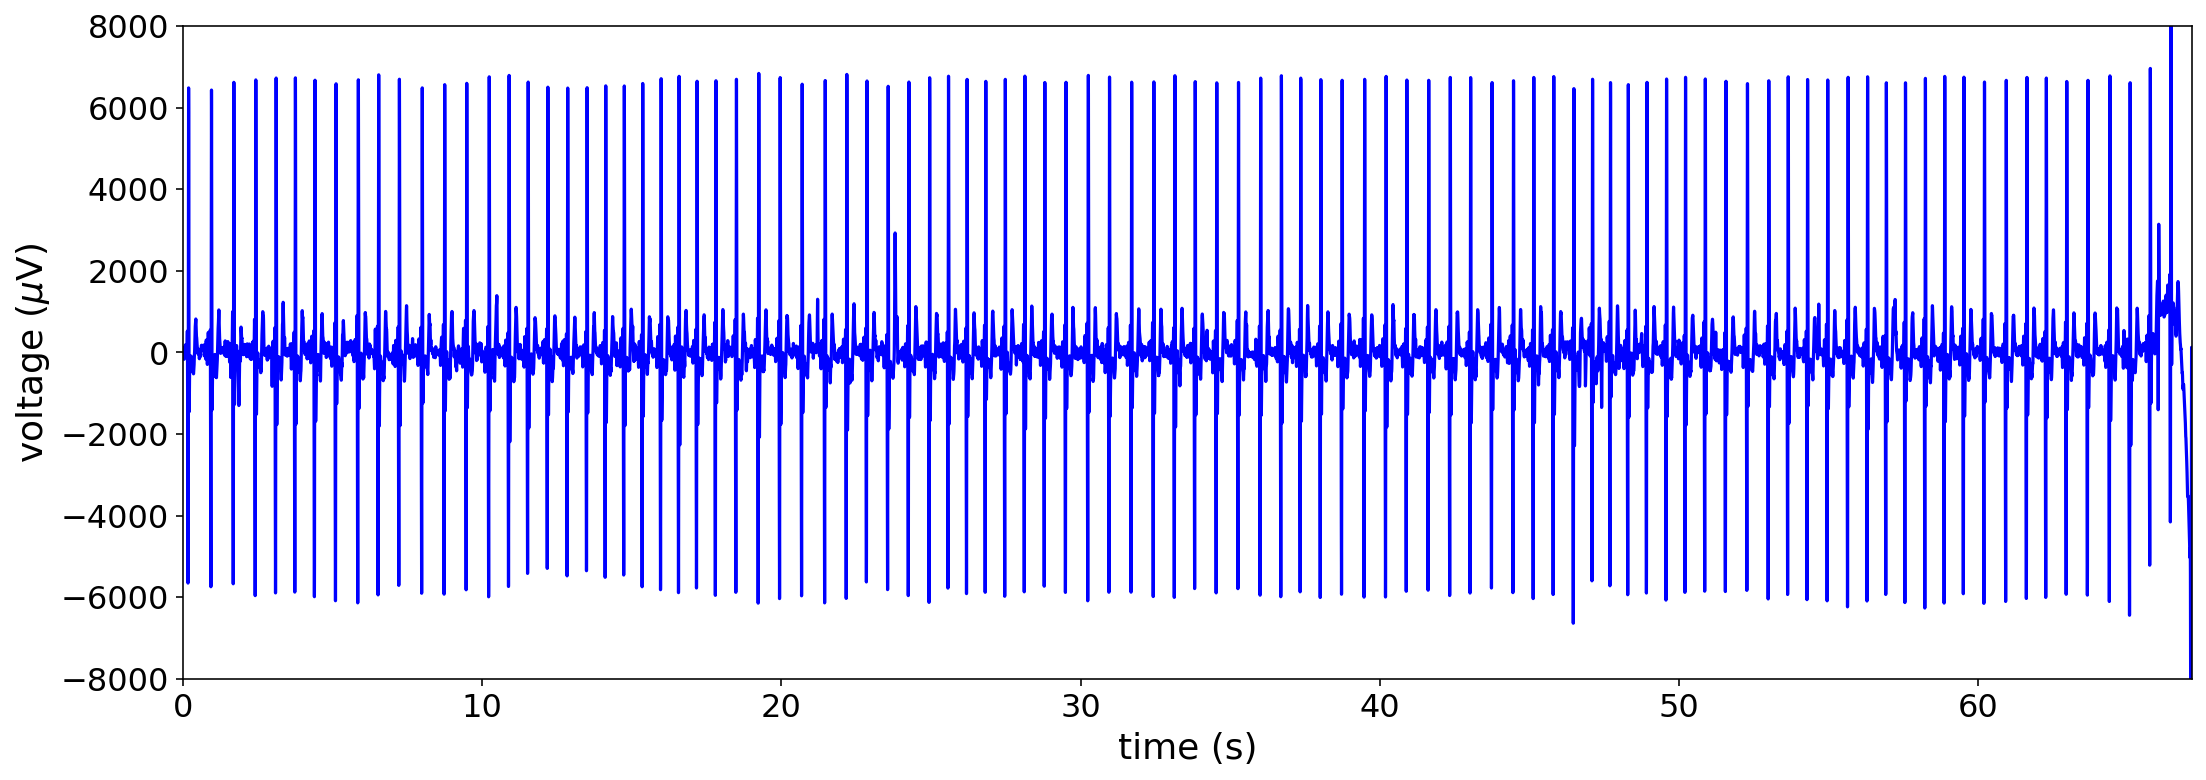

In [101]:
# plotting entire filtered ECG recording
plt.figure(figsize=(18,6))
plt.xlabel(r'time (s)')
plt.ylabel(r'voltage ($\mu$V)')
plt.plot(xx['timeECG'],databf, 'b')
plt.xlim(0,max(xx['timeECG']))
plt.ylim(-8000,8000);

From the above, it looks like we have stable sections of the recording in the time intervals $\sim$0-22s, $\sim$25-45s, and $\sim$50-55s. Let's go with the first section.

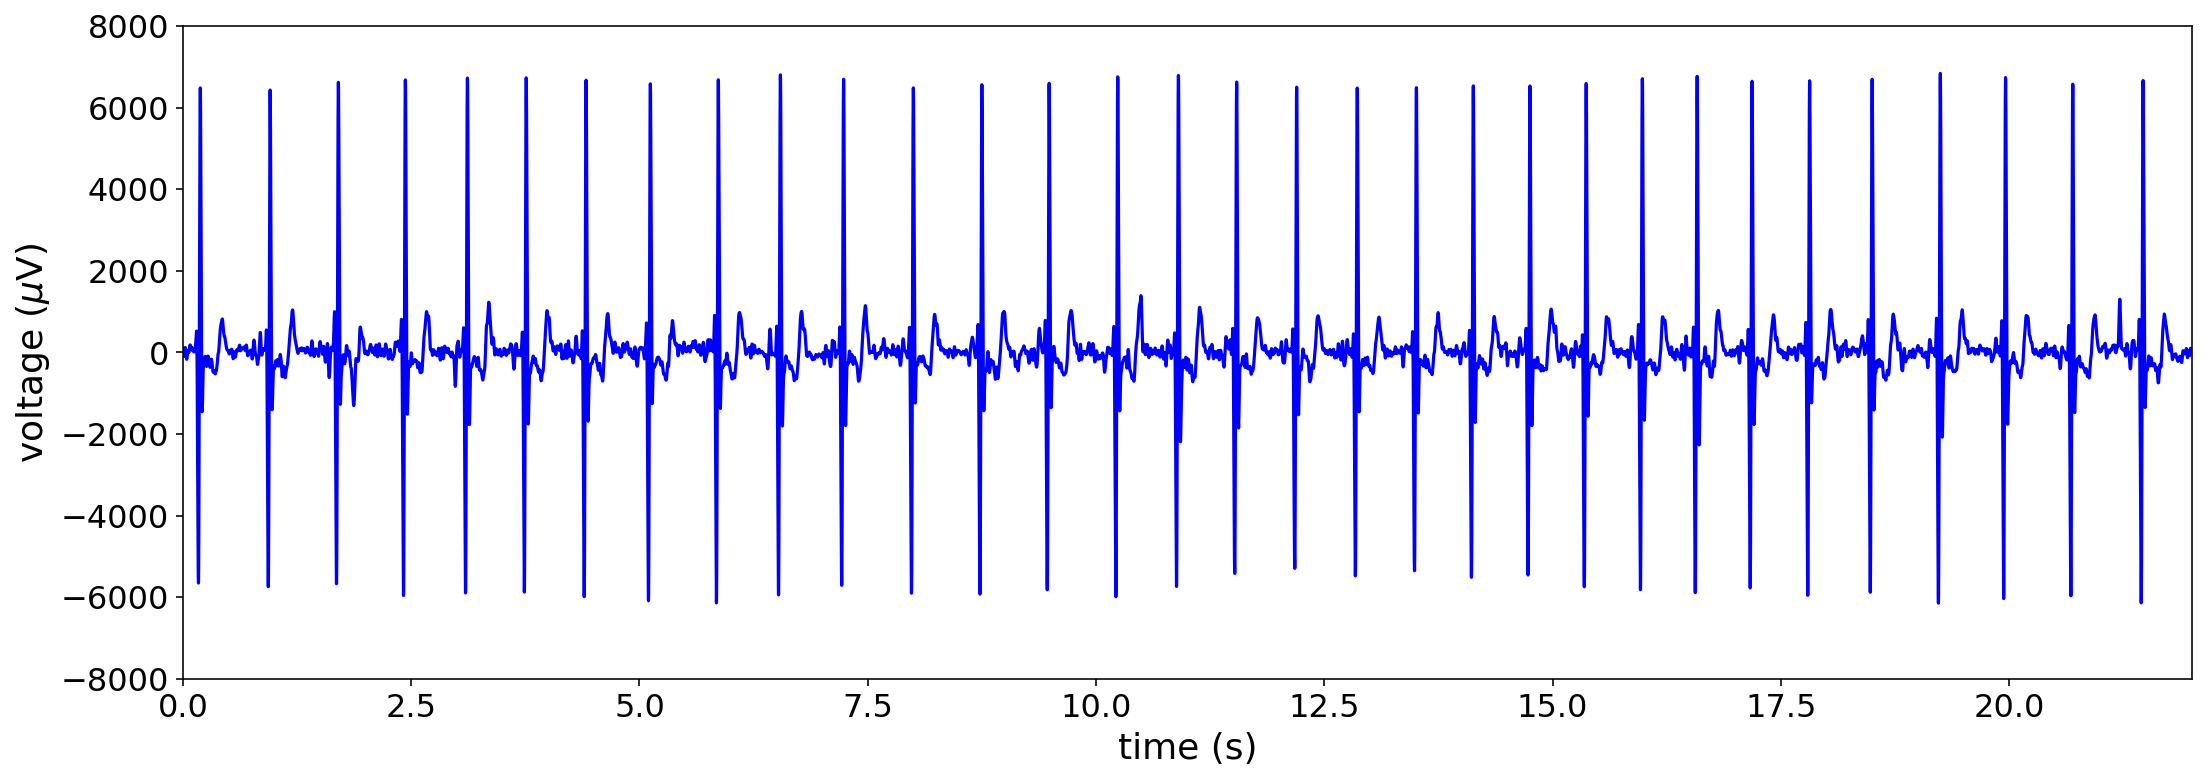

In [102]:
# plotting first stable time interval
plt.figure(figsize=(18,6))
plt.xlabel(r'time (s)')
plt.ylabel(r'voltage ($\mu$V)')
plt.plot(xx['timeECG'],databf, 'b')
plt.xlim(0,22)
plt.ylim(-8000,8000);

Now let's define the start and end points (n1 and n2) and multiple by the sampling rate to define where we will cut the recording. Then, we'll redefine the time and data series to only include points within these limits.

In [103]:
# define points where we will cut recording
n1 = 0.0
n2 = 22.0

m1 = int(n1*10000)
m2 = int(n2*10000)

# redefine times and data to be between cut points
timesLim, dataLim = xx['timeECG'][m1:m2], databf[m1:m2]

Once we have the cut recording with a stable section, we can move on to detecting the ECG components. 

## R peaks
We'll start by detecting the R peaks, which can be used to calculate the heart rate (cardiac frequency) and also things like R-R intervals and cardiac variability. Note that for the detection to work properly, the recording should have the following characteristics:

- Stable baseline
- R peaks are greater in amplitude than the maximum value of the T wave
- R peaks have roughly the same amplitude across cycles

In [104]:
"""
The following function creates an array of values which are found to surpass a certain threshold within the ECG. 
Afterwards, it determines the maximum value of this array and adds it in the R-vector. 
This process is repeated until the end of the time series. 
If not all the R peaks are detected, you can decrease the tRatio value.
If components that are not R peaks (like T waves) are detected, you can increase the tRatio value.
"""
def Rpeaks(times,data,tRatio=0.7):
    interval = max(data) - min(data)
    threshold = tRatio*interval + min(data)
    maxima = []
    maxInds = []
    mxsInds = []
    banner = False
    
    for i in range(0,len(data)):
         
        if data[i] >= threshold: 
            """If threshold value is surpassed, then indices and values are saved""" 
            banner = True
            maxInds.append(i)
            maxima.append(data[i])
            
        elif banner == True and data[i] < threshold: 
            """If threshold value is crossed, then index of the maximum value in the original array is saved"""
            indMax = maxima.index(max(maxima))
            mxsInds.append(maxInds[indMax])
             
            maxima = []
            maxInds = [] 
            banner = False       

    return mxsInds

Now we can run the function and graph the result to make sure the R peaks are detected properly.

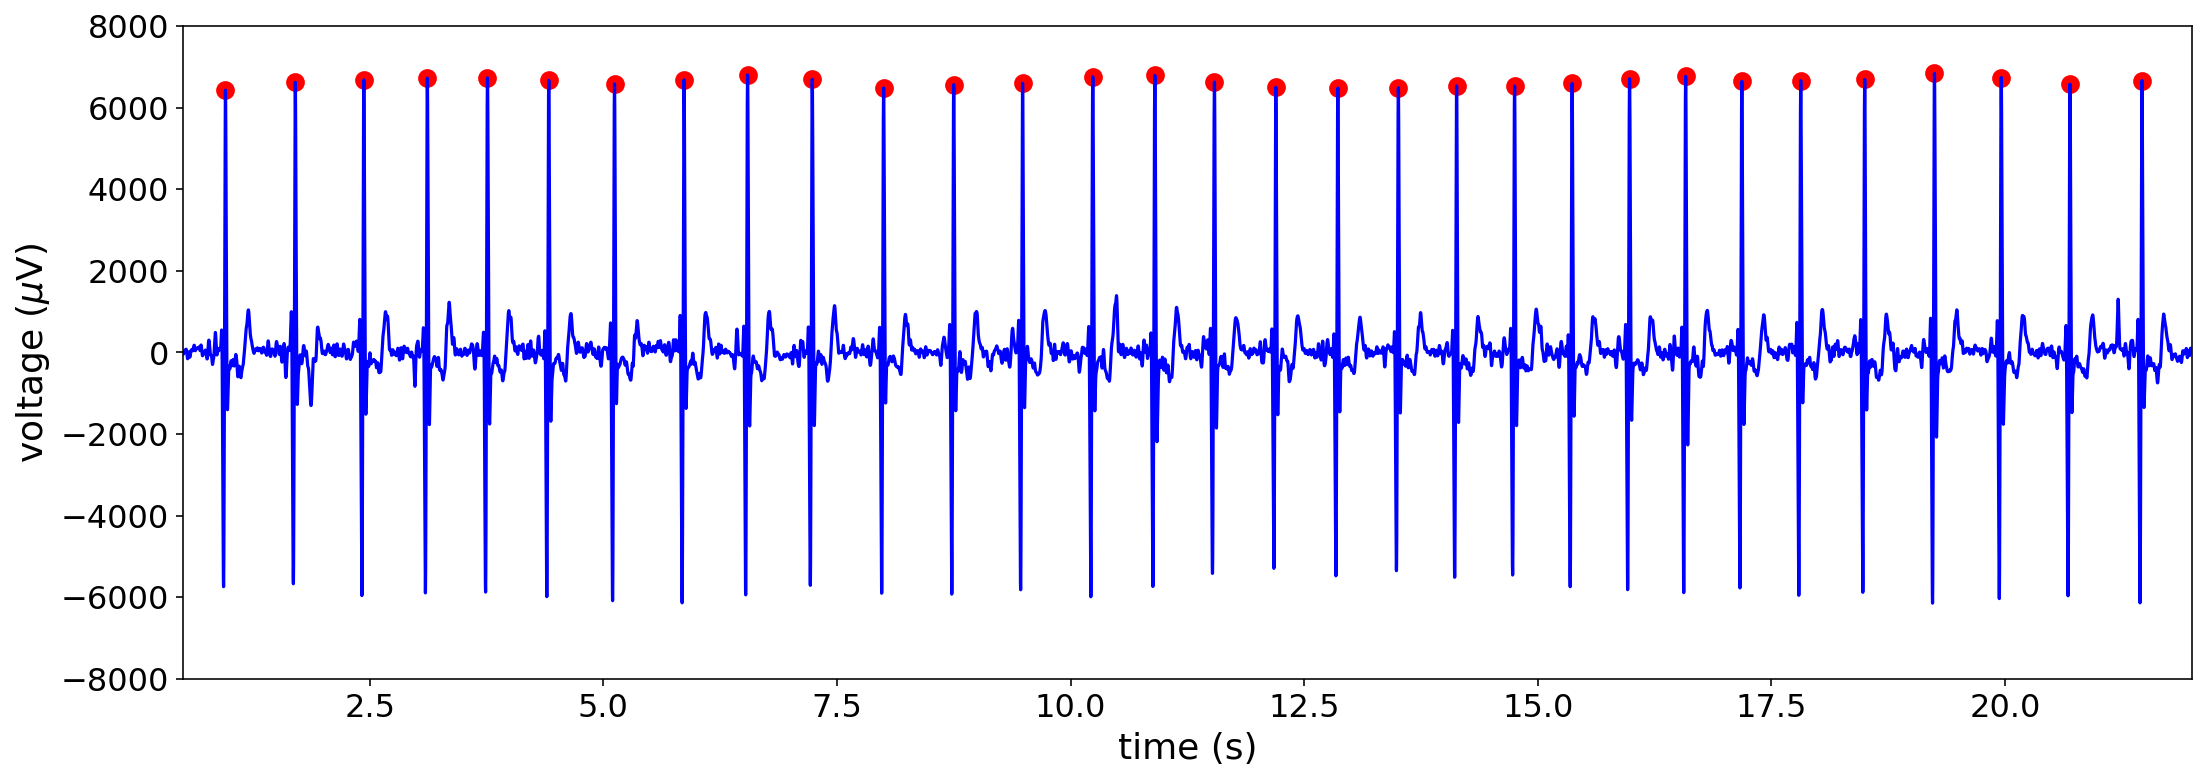

In [105]:
mxsInds = Rpeaks(times=timesLim,data=dataLim,tRatio=0.7) # run function on band-pass filtered data

plt.figure(figsize=(18,6))
plt.xlabel(r'time (s)')
plt.ylabel(r'voltage ($\mu$V)')
plt.plot(xx['timeECG'],databf, 'b')
plt.scatter(xx['timeECG'][mxsInds],databf[mxsInds], color='r', s=70) # red dots mark the detected R peaks
plt.xlim(0.5,22)
plt.ylim(-8000,8000);

## Heart rate and R-R intervals
Once we have the R peaks, we can calculate things like the heart rate and R-R intervals. We can start by calculating the mean heart rate (beats per minute) over the whole course of the ECG recording.

In [106]:
# calculate the heart rate (beats per minute) and express as an integer
meanBPM = 60*(len(mxsInds)/(timesLim[-1]-timesLim[0]))
print("Beats per minute:", int(meanBPM)) 

Beats per minute: 87


We can also look at how the instantaneous heart rate varies over the course of the recording, i.e. across ECG cycles and graph the results. 

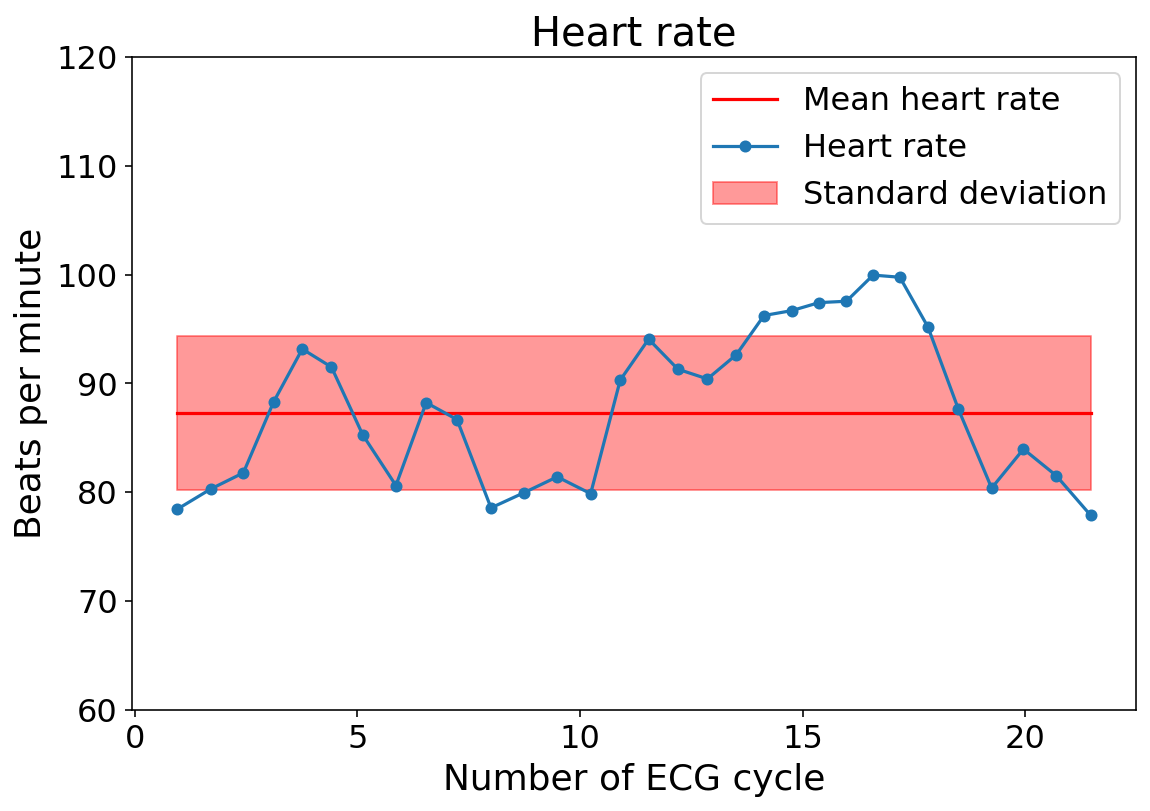

In [107]:
# calculate instantaneous heart rate as it varies over ECG cycles
heartRate = [(60/(timesLim[mxsInds[i+1]]-timesLim[mxsInds[i]])) for i in range(0, len(mxsInds)-1)]
time = timesLim[mxsInds]

# calculate mean, standard deviation of the heart rate
meanVec = [meanBPM for i in range(0, len(time)-1)]
stdPlus = [meanBPM+stdev(heartRate) for i in range(0, len(time)-1)]
stdMinus = [meanBPM-stdev(heartRate) for i in range(0, len(time)-1)]

# plot results
plt.figure(figsize=(9,6))
plt.fill_between(time[1:], stdMinus, stdPlus, facecolor="red", label = "Standard deviation", color='red', alpha=0.4)
plt.plot(time[1:], meanVec, c="r", label = "Mean heart rate")
plt.plot(time[1:], heartRate, markersize=5, marker = "o", label="Heart rate")
plt.title("Heart rate")
plt.xlabel(r'Number of ECG cycle')
plt.ylabel(r'Beats per minute')
plt.ylim((60, 120))
plt.legend();

We can also calculate the R-R intervals, or the time between R peaks, which is another measure that can be used to compare different levels of physical activity or diagnose clinical conditions. Notice that the heart rate and R-R interval calculations are related: the heart rate is the inverse of the R-R interval multiplied by 60 to obtain the number of beats per minute.

In [108]:
# function to calculate the RR intervals
def Rints(times):
    length = len(times)
    Rints = np.zeros(length-1)
    
    for i in range(0, length-1):
        Rints[i] = times[i+1]-times[i]
    
    return Rints

# calculate the RR intervals, get the mean, standard deviation
xx = Rints(timesLim[mxsInds])
meanRR = np.mean(xx)
print("Mean R-R interval:", round(meanRR,2),'seconds')

meanVec = [meanRR for i in range(0, len(time)-1)]
stdPlus = [meanRR+stdev(xx) for i in range(0, len(time)-1)]
stdMinus = [meanRR-stdev(xx) for i in range(0, len(time)-1)]

Mean R-R interval: 0.69 seconds


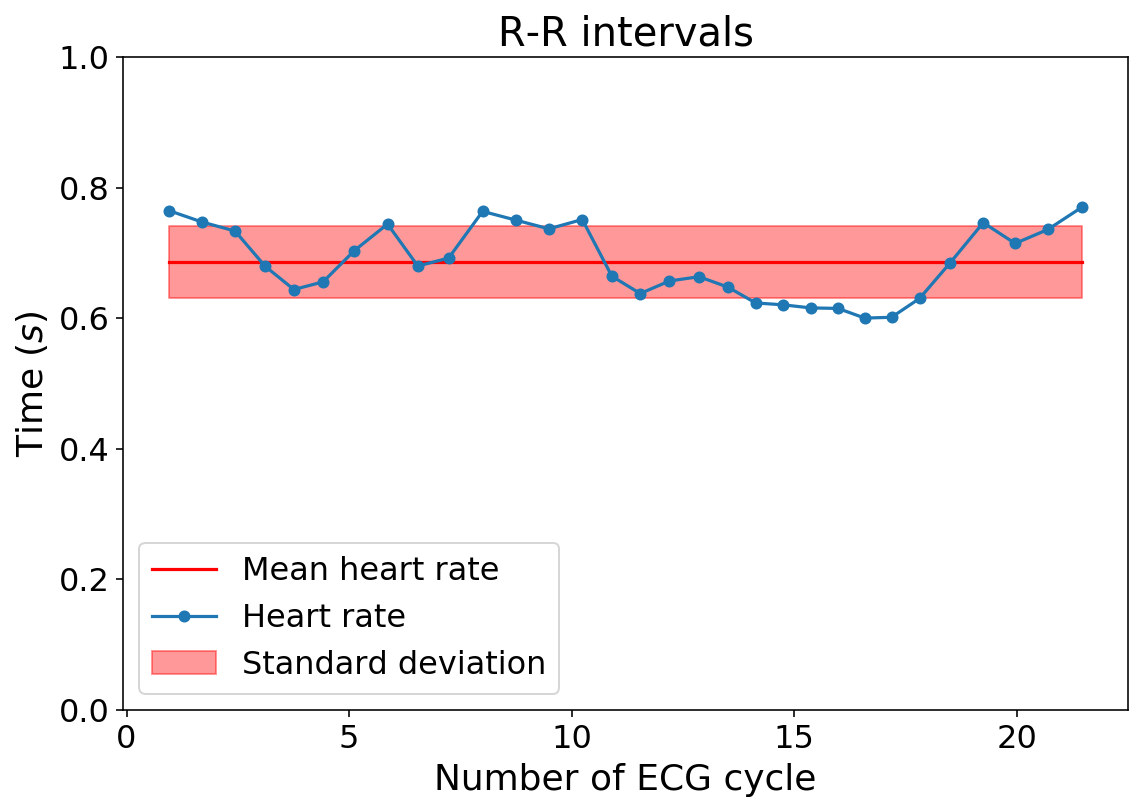

In [109]:
# plot results
plt.figure(figsize=(9,6))
plt.fill_between(time[1:], stdMinus, stdPlus, facecolor="red", label = "Standard deviation", color='red', alpha=0.4)
plt.plot(time[1:], meanVec, c="r", label = "Mean heart rate")
plt.plot(time[1:], xx, markersize=5, marker = "o", label="Heart rate")
plt.ylim((0, 1))
plt.title("R-R intervals")
plt.xlabel(r'Number of ECG cycle')
plt.ylabel(r'Time ($s$)')
plt.legend()
plt.show()

## QRS complex

Next, we can detect and measure the QRS complex, which represents the period of primary depolarization in the ventricles. The detection builds upon the previous R peak detection (using the max indices) and then finds the minimum values to the left (Q) and right (S) of those peaks. The normal QRS width is $\sim$0.07-0.10s (i.e., 70-100ms). Values beyond this range can indicate clinical conditions, including problems with the propagation of electrical signals.   

In [110]:
# find minimums to the left and right of R peaks 
mins = []
i=0

for i in mxsInds:
    leftInt = dataLim[i-700:i]
    rightInt = dataLim[i:i+700]
    
    mins.append(i - 700 + (list(leftInt).index(min(leftInt))) )
    mins.append(i + (list(rightInt).index(min(rightInt))) )

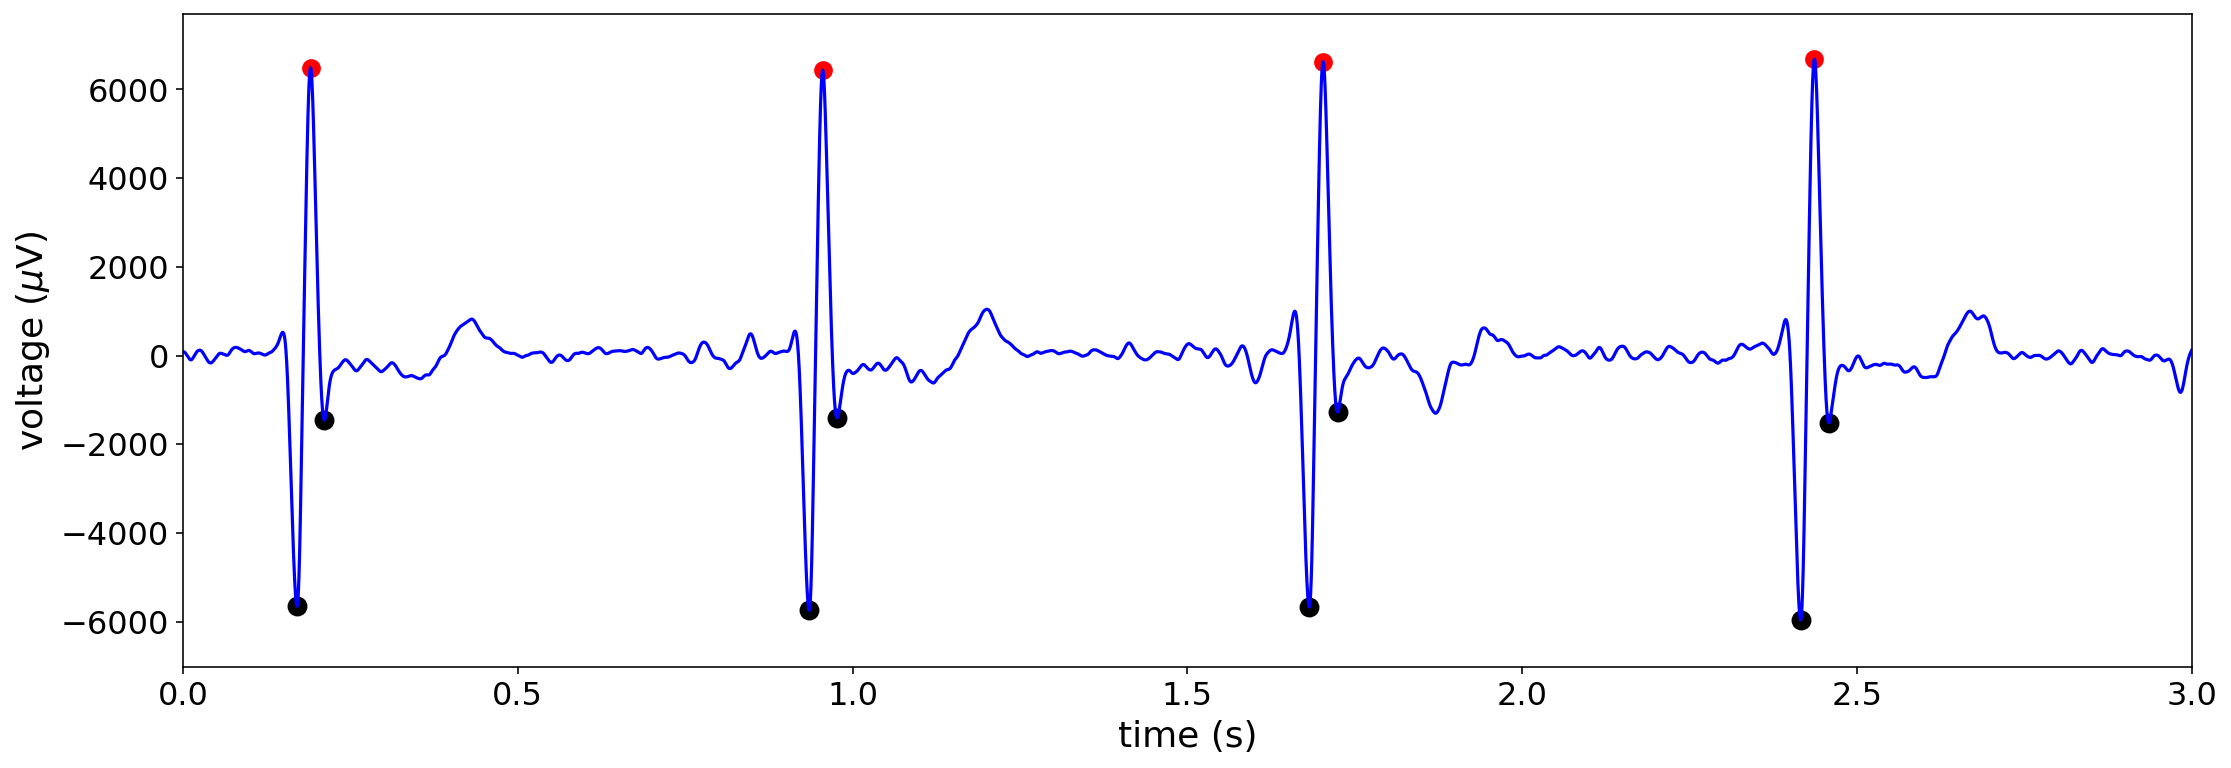

In [111]:
# plot QRS detection (just a few cycles to better see detection)
plt.figure(figsize=(18,6))
plt.xlabel(r'time (s)')
plt.ylabel(r'voltage ($\mu$V)')
plt.xlim(min(timesLim),3)
plt.plot(timesLim, dataLim, color='b')
plt.scatter(timesLim[mxsInds], dataLim[mxsInds], color='r', s=70)
plt.scatter(timesLim[mins], dataLim[mins], color='k', s=80);

Now that the detection is working properly, we can calculate the mean duration of the QRS intervals.

In [112]:
# calculate the duration of the QRS complexes
QRSdur = np.zeros(len(mxsInds))

for i in range(0, len(mxsInds)):
    QRSdur[i] = timesLim[mins[i*2 + 1]] - timesLim[mins[i*2]]
    
meanQRS = np.mean(QRSdur)
print("Mean QRS complex duration:", round(meanQRS,2),'seconds')

meanVec = [meanQRS for i in range(0, len(QRSdur))]
stdPlus = [meanQRS+stdev(QRSdur) for i in range(0, len(QRSdur))]
stdMinus = [meanQRS-stdev(QRSdur) for i in range(0, len(QRSdur))]

Mean QRS complex duration: 0.04 seconds


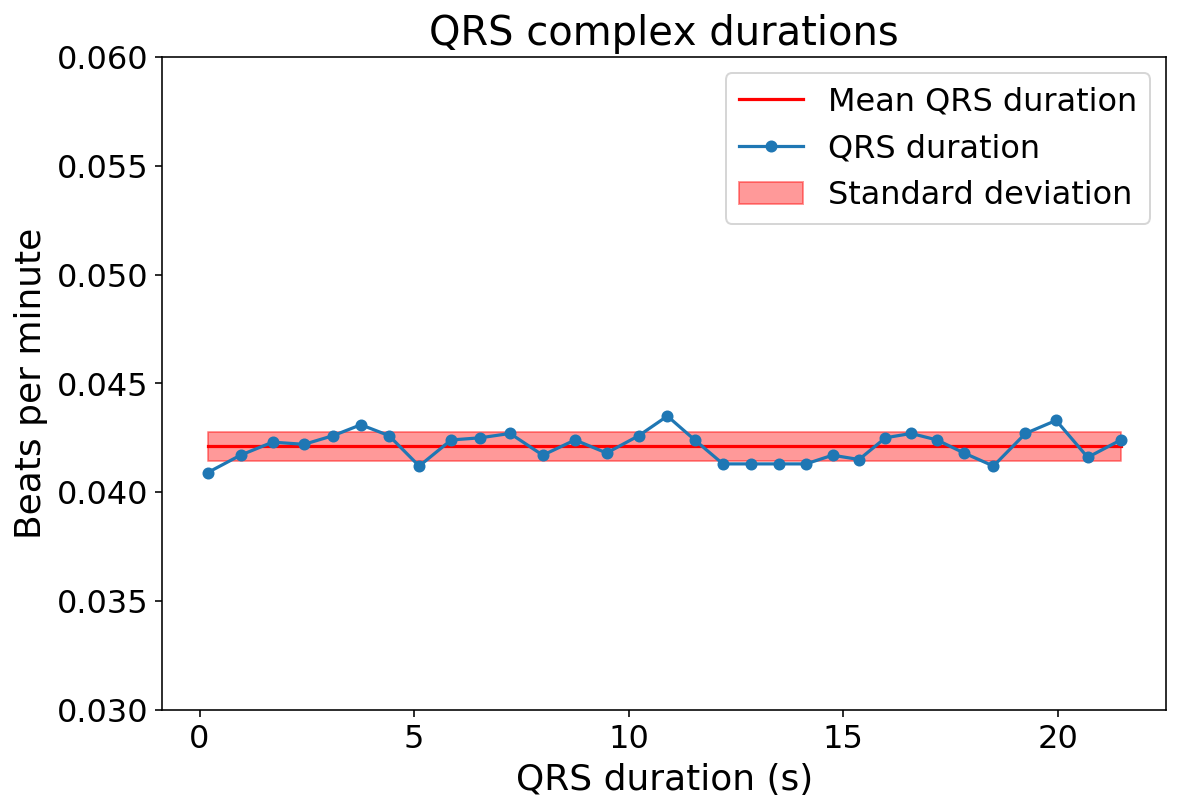

In [113]:
# plot results
plt.figure(figsize=(9,6))
plt.fill_between(time, stdMinus, stdPlus, facecolor="red", label = "Standard deviation", color='red', alpha=0.4)
plt.plot(time, meanVec, c="r", label = "Mean QRS duration")
plt.plot(time, QRSdur, markersize=5, marker = "o", label="QRS duration")
plt.title("QRS complex durations")
plt.xlabel(r'QRS duration (s)')
plt.ylabel(r'Beats per minute')
plt.ylim((0.03, 0.06))
plt.legend();

## P wave

The P wave is the first significant electrical event recorded in the ECG during the cardiac cycle, representing depolarization in the atria. To detect the P wave, we can use the R peaks as a reference point. The normal time interval between the P wave and the R peak is $\sim$0.12-0.20s. Therefore, to be safe, we can start looking for the P wave about 0.3 s before the R peak. Given the shape of the P wave, we know there will be two inflection points (changes in concavity), one at the beginning and another at the end of the P wave. So we start by obtaining the discrete derivative of the time series.

In [114]:
nn = 3000 # 0.3 seconds
window = 200 # window for obtaining derivative
pStart = []
deriv = []

for i in range(0, len(mxsInds)):
    
    for j in range(0, nn-500):
        index = mins[i*2] - nn + j
        aux = (dataLim[index+window]-dataLim[index])/(timesLim[index+window] - timesLim[index])
        deriv.append(aux) 

        if aux > 25000: # move this parameter until you find the correct threshold
            pStart.append(index)
            break

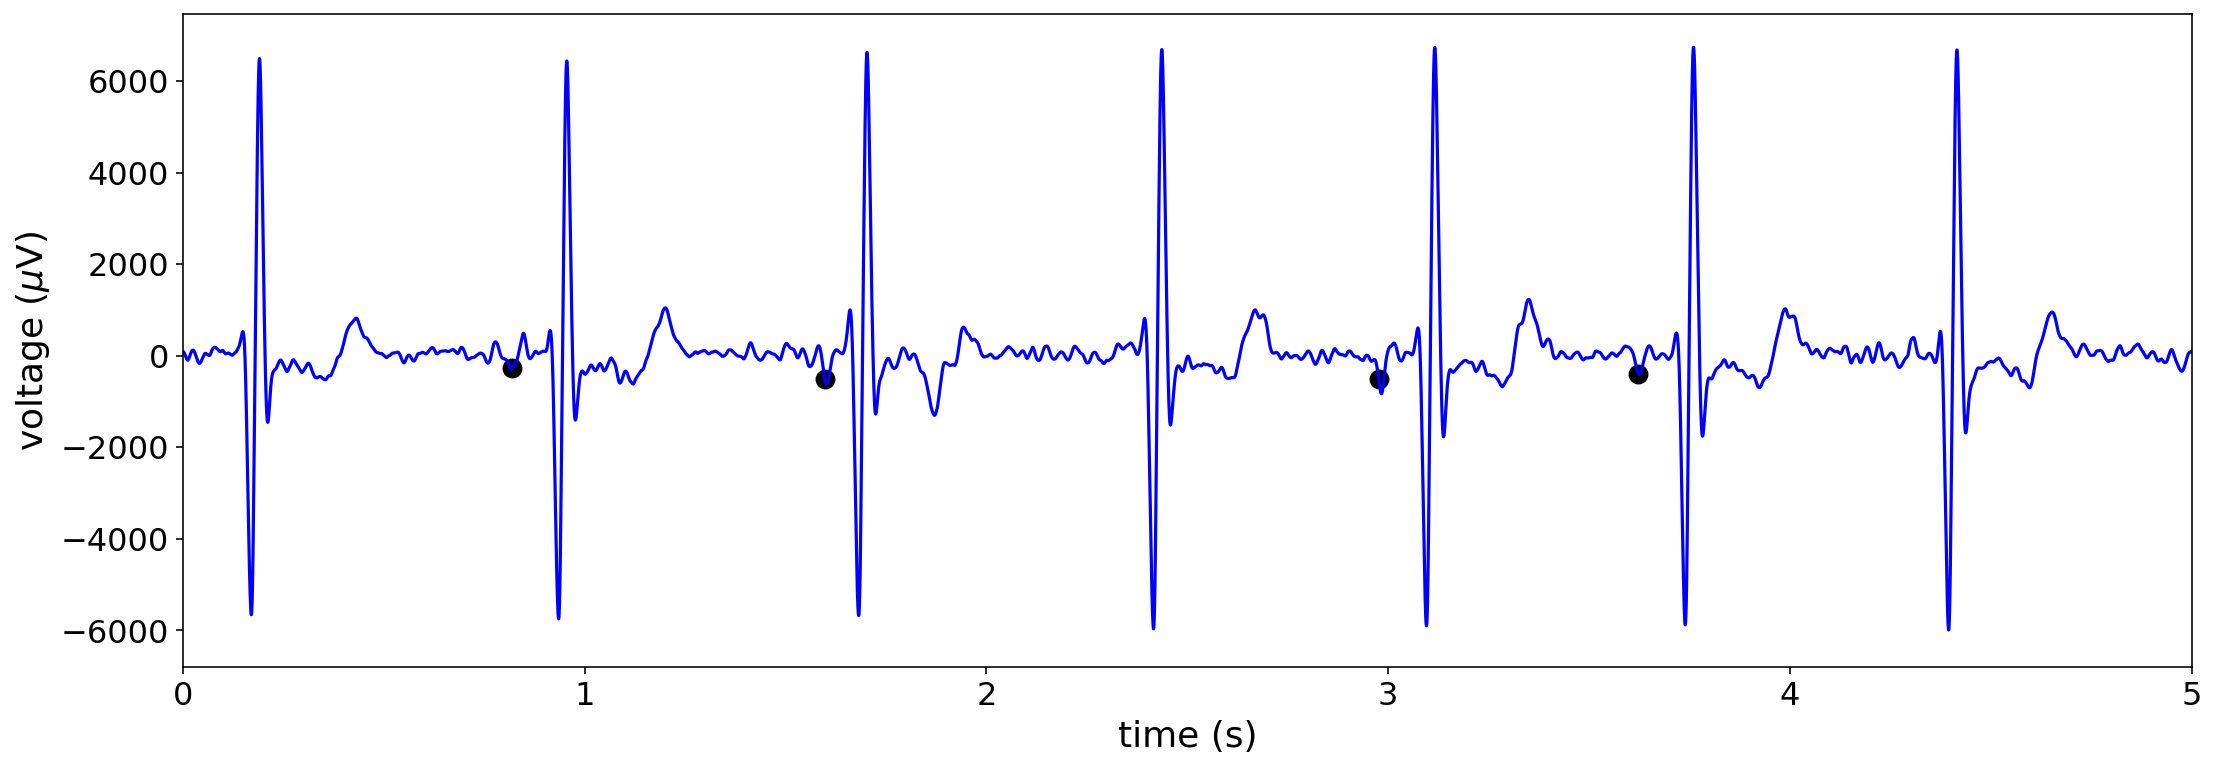

In [115]:
plt.figure(figsize=(18,6))
plt.xlabel(r'time (s)')
plt.ylabel(r'voltage ($\mu$V)')
plt.xlim(0,5.0)
plt.plot(timesLim[start*10000:end*10000],dataLim[start*10000:end*10000], 'b')
plt.scatter(timesLim[pStart],dataLim[pStart], color='k', s=80);

We can see that here we run into our first problem with the detection. This recording does not have a prominent P wave. (Note that this is due to issues with the sensitivity of the recording equipment and/or problems with electrode placement, rather than an indication of a physiological problem.) So, let's look for another recording with a noticeable P wave to test the detection algorithm.

Now we wish to find the end of the P wave.
We know that this will happen when the ECG signal has again the same value as in the start of the P wave.

In [31]:
p_wave_end = []
for p_wave_i in p_wave_begin:
    truth = False
    index = 200
    while truth == False:
        if waveData[p_wave_i+index] <= waveData[p_wave_i] and waveData[p_wave_i] > waveData[p_wave_i+index+1]:
            p_wave_end.append(p_wave_i+index)
            truth = True
        index +=1

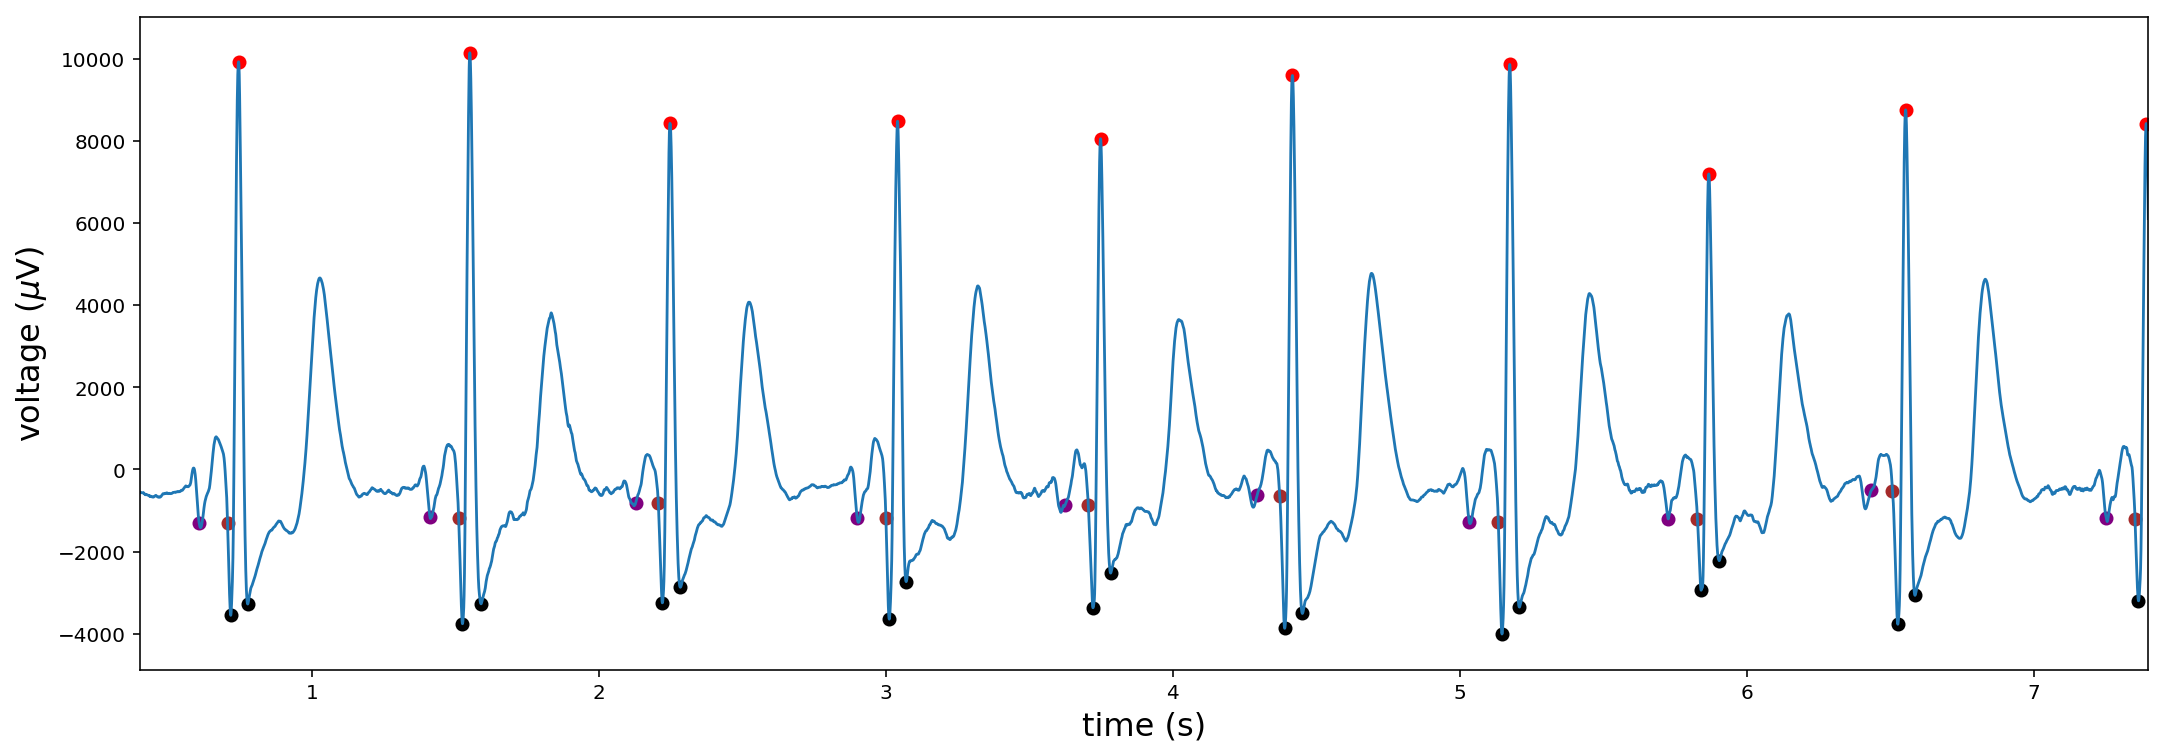

In [32]:
init_sec = 0
fin_sec = 7
plt.figure(figsize=(18,6))
plt.xlabel(r'time (s)')
plt.ylabel(r'voltage ($\mu$V)')
plt.xlim(timeECG[init_sec*10000],timeECG[fin_sec*10000])
plt.plot(timeECG[init_sec*10000:fin_sec*10000], waveData[init_sec*10000:fin_sec*10000])
plt.scatter(timeECG[mxs_indices], waveData[mxs_indices], color='r')
plt.scatter(timeECG[mins_try], waveData[mins_try], color='k')
plt.scatter(timeECG[p_wave_begin], waveData[p_wave_begin], color='purple')
plt.scatter(timeECG[p_wave_end], waveData[p_wave_end], color='brown')
plt.show()

In [33]:
# p wave intervals:
if len(p_wave_begin) != len(p_wave_end):
    print("Check the array lengths because they are different.")
    
p_wave_time = np.zeros(len(p_wave_begin)-1)
for i in range(1, len(p_wave_begin)):
    p_wave_time[i-1] = timeECG[p_wave_end[i]] - timeECG[p_wave_begin[i]]
    
mean_p_wave = np.mean(p_wave_time)
print("Mean in seconds of the P-wave: ",mean_p_wave)

mean_vec = [mean_p_wave for i in range(0, len(time)-1)]
std_vec_plus = [mean_p_wave+stdev(p_wave_time) for i in range(0, len(time)-1)]
std_vec_minus = [mean_p_wave-stdev(p_wave_time) for i in range(0, len(time)-1)]

Mean in seconds of the P-wave:  0.09061157839306573


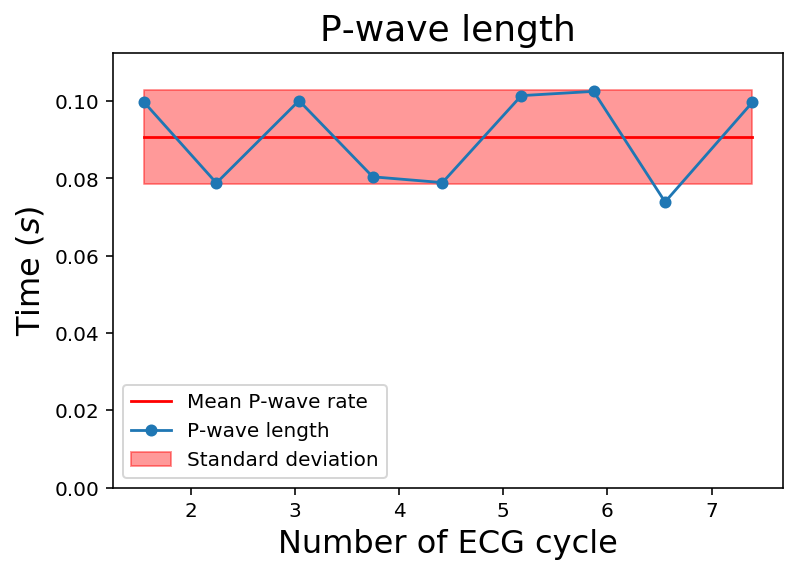

In [34]:
plt.fill_between(time[1:], std_vec_minus, std_vec_plus, facecolor="red",
                 label = "Standard deviation", color='red', alpha=0.4)
plt.plot(time[1:], mean_vec, c="r", label = "Mean P-wave rate")
plt.plot(time[1:], p_wave_time, markersize=5, marker = "o", label="P-wave length")
plt.ylim((0, max(p_wave_time)+0.01))
plt.title("P-wave length")
plt.xlabel(r'Number of ECG cycle')
plt.ylabel(r'Time ($s$)')
plt.legend()
plt.show()

# T wave

The normal QT interval is below 450 ms for men and below 460 ms for women [ECGpedia, 2013]. Based on this, we will start looking for the T wave 300 ms after the R peak.

The duration of the T Wave is 0.10 to 0.25 seconds or greater [Nurses Learning, 1999].

In [35]:
nn = 1500 #0.15 seconds
t_wave_begin = []
interval_der = 200 #window for obtaining derivative
time_derivative_vec = []
for mxs_i in range(0, len(mxs_indices)):
    
    for i in range(0, nn-500):
        index = mins_try[mxs_i*2] + nn + i
        aux = (waveData[index+interval_der]-waveData[index])/(timeECG[index+interval_der] - timeECG[index])
        time_derivative_vec.append(aux) 

        if aux > 25000: #Move this parameter until you find the correct threshold
            t_wave_begin.append(index)
            break

For identifying the end of the T wave we will also consider an inflection point. We are not using the same idea as in the end of the P wave because when looking at the graphs, the end of the T wave does not have the same value as the beginning of the T wave. This is because the recording does not have a stable baseline.

In [36]:
# t_wave_end
nn = 3000 #0.3 seconds
t_wave_end = []
interval_der = 100 #window for obtaining derivative
time_derivative_vec = [0]
for mxs_i in range(0, len(mxs_indices)):
    
    for i in range(0, nn-500):
        index = mins_try[mxs_i*2] + nn + i
        aux = (waveData[index+interval_der]-waveData[index])/(timeECG[index+interval_der] - timeECG[index])
        time_derivative_vec.append(aux) 

        if time_derivative_vec[i] > 0 and time_derivative_vec[i-1] < 0: #Move this parameter until you find the correct threshold
        #We are looking for the inflection point where the derivative changes from being negative to being positive
            t_wave_end.append(index)
            break

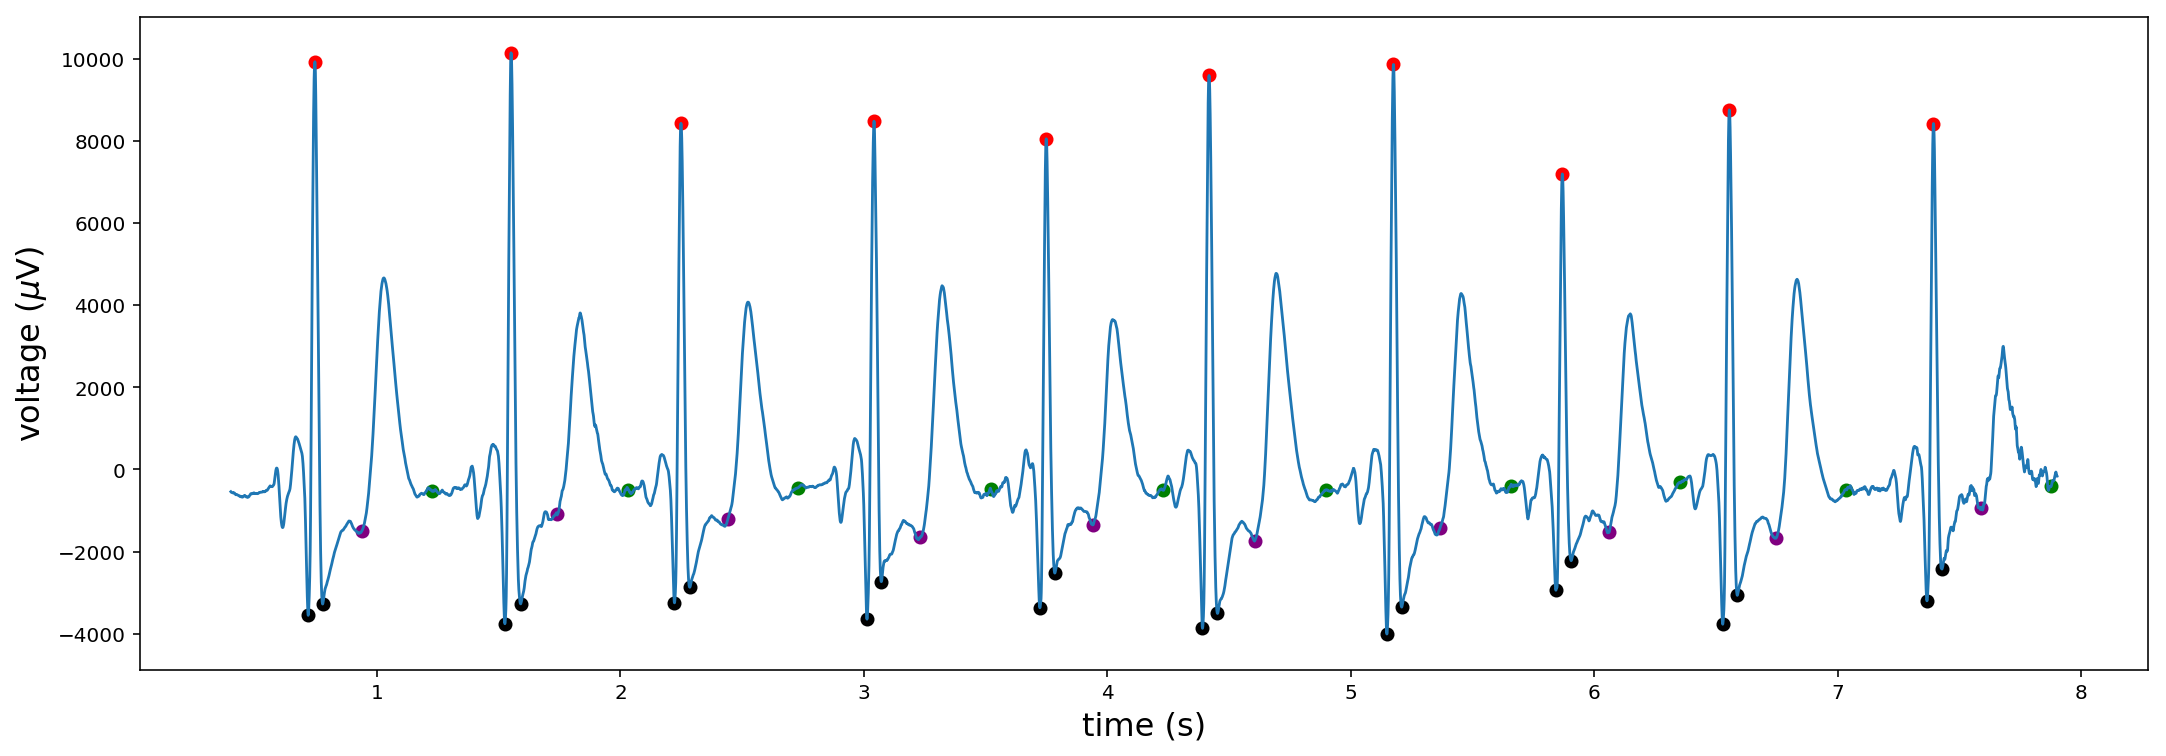

In [37]:
plt.figure(figsize=(18,6))
plt.xlabel(r'time (s)')
plt.ylabel(r'voltage ($\mu$V)')
plt.plot(timeECG, waveData)
plt.scatter(timeECG[mxs_indices], waveData[mxs_indices], color='r')
plt.scatter(timeECG[mins_try], waveData[mins_try], color='k')
plt.scatter(timeECG[t_wave_begin], waveData[t_wave_begin], color='purple')
plt.scatter(timeECG[t_wave_end], waveData[t_wave_end], color='green')
plt.show()

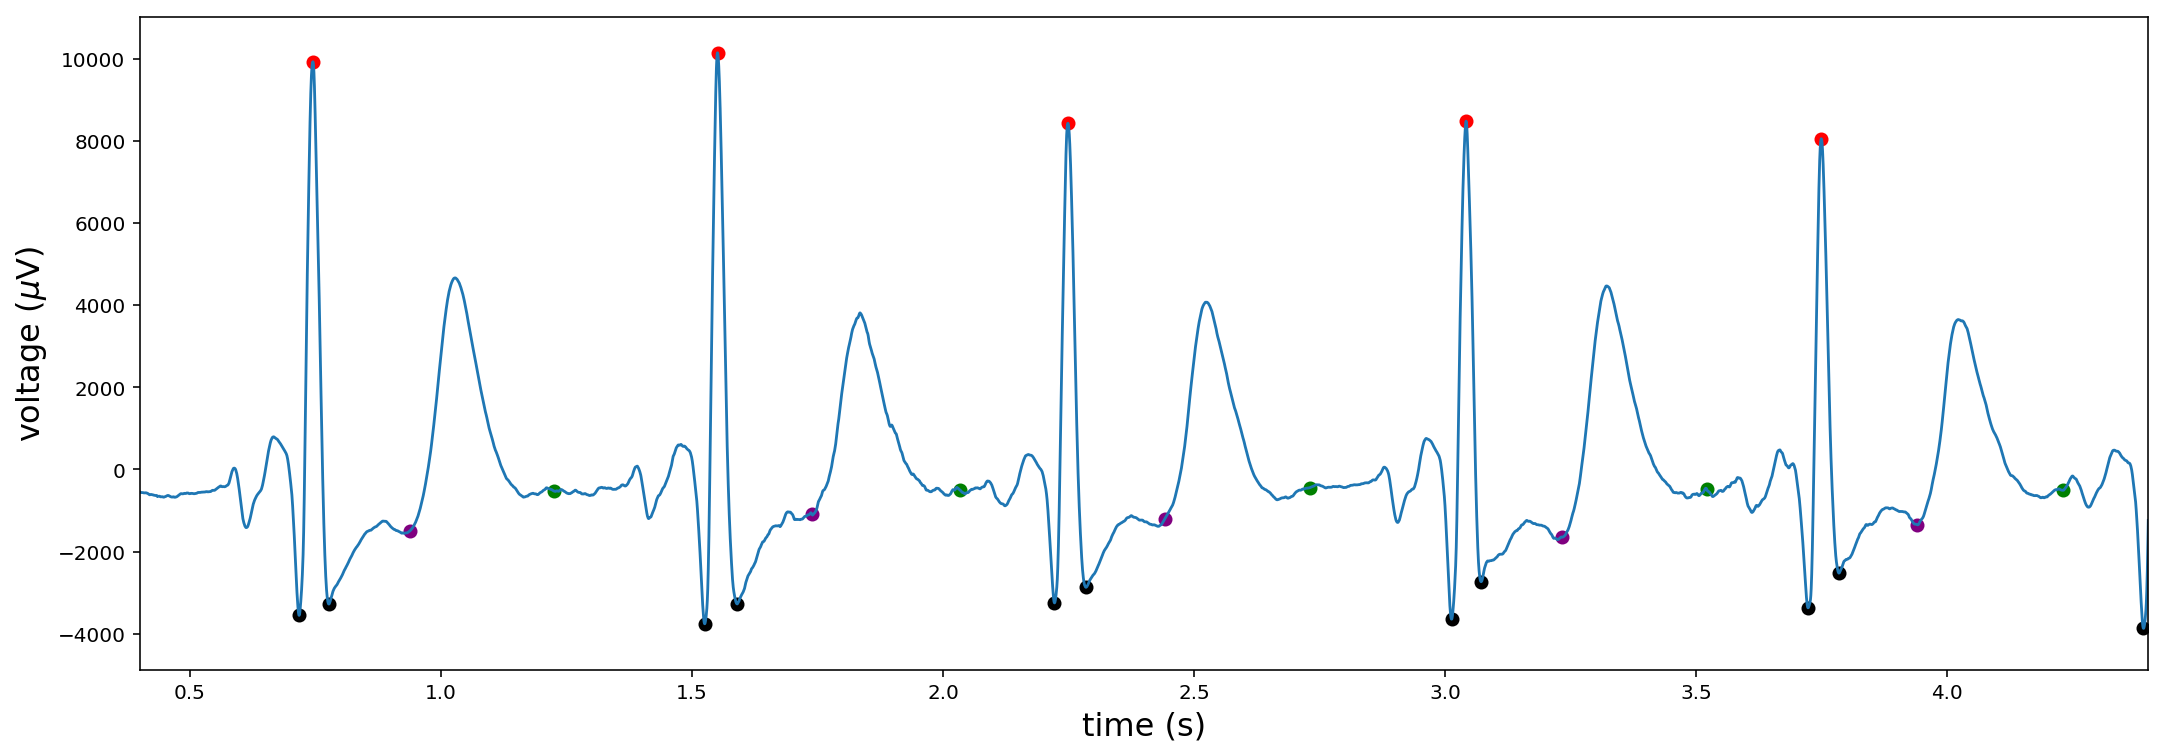

In [38]:
#Close up
init_sec = 0
fin_sec = 4
plt.figure(figsize=(18,6))
plt.xlabel(r'time (s)')
plt.ylabel(r'voltage ($\mu$V)')
plt.xlim(timeECG[init_sec*10000],timeECG[fin_sec*10000])
plt.plot(timeECG[init_sec*10000:fin_sec*10000], waveData[init_sec*10000:fin_sec*10000])
plt.scatter(timeECG[mxs_indices], waveData[mxs_indices], color='r')
plt.scatter(timeECG[mins_try], waveData[mins_try], color='k')
plt.scatter(timeECG[t_wave_begin], waveData[t_wave_begin], color='purple')
plt.scatter(timeECG[t_wave_end], waveData[t_wave_end], color='green')
plt.show()

In [39]:
# t wave intervals:
if len(t_wave_begin) != len(t_wave_end):
    print("Check the array lengths because they are different.")
    
t_wave_time = np.zeros(len(t_wave_begin)-1)
for i in range(1, len(t_wave_begin)):
    t_wave_time[i-1] = timeECG[t_wave_end[i]] - timeECG[t_wave_begin[i]]
    
# Mean time for t wave
mean_t_wave = np.mean(t_wave_time)
print("Mean in seconds of the T-wave: ",mean_t_wave)

mean_vec = [mean_t_wave for i in range(0, len(time)-1)]
std_vec_plus = [mean_t_wave+stdev(t_wave_time) for i in range(0, len(time)-1)]
std_vec_minus = [mean_t_wave-stdev(t_wave_time) for i in range(0, len(time)-1)]

Mean in seconds of the T-wave:  0.29012371838397794


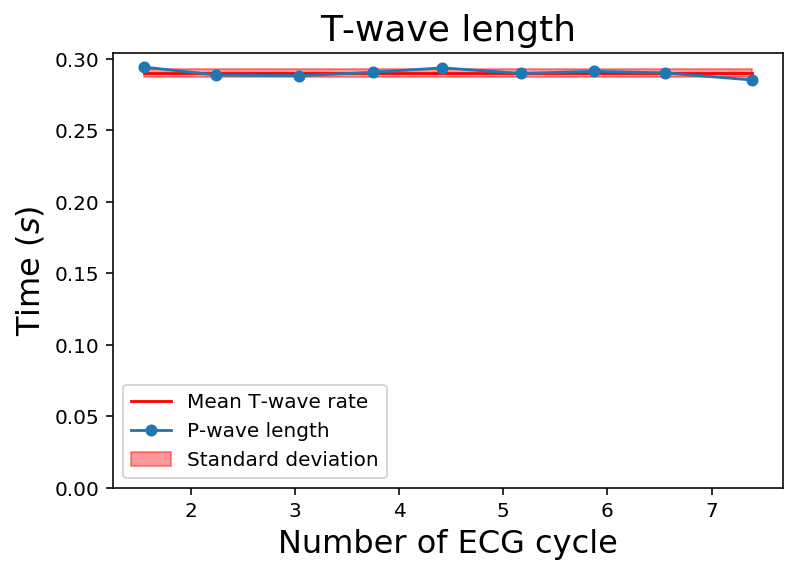

In [40]:
plt.fill_between(time[1:], std_vec_minus, std_vec_plus, facecolor="red",
                 label = "Standard deviation", color='red', alpha=0.4)
plt.plot(time[1:], mean_vec, c="r", label = "Mean T-wave rate")
plt.plot(time[1:], t_wave_time, markersize=5, marker = "o", label="P-wave length")
plt.ylim((0, max(t_wave_time)+0.01))
plt.xlabel(r'Number of ECG cycle')
plt.ylabel(r'Time ($s$)')
plt.title("T-wave length")
plt.legend()
plt.show()

This is in agreent that the T-wave lasts 0.1 to 0.25 seconds or more [Nurses Learning, 1999].